<xarray.DatasetView> Size: 4MB
Dimensions:                    (time: 122070, individuals: 2)
Coordinates:
  * time                       (time) float64 977kB 20.0 20.0 20.0 ... 25.0 25.0
  * individuals                (individuals) <U21 168B 'male (red radio)' 'fe...
Data variables:
    vibration (accelerometer)  (time, individuals) float32 977kB ...
    labels                     (time, individuals) float64 2MB ...
Attributes:
    fps:       47.6837158203125
    audio_sr:  24414.0625
    cameras:   cam1
    cam1:      copExpBP08_trim.mp4
    mics:      mic1
    mic1:      copExpBP08_trim.wav
    trial:     sample_trial

In [2]:
path = r"C:\Users\aksel\Documents\Code\EthoGraph\tests\test_data\copExpBP08_trim.nc"
from ethograph import TrialTree
dt = TrialTree.open(path)
signal = dt.itrial(0)["vibration (accelerometer)"].isel(individuals=0).values
signal

array([623530.7 , 623651.6 , 623858.  , ..., 626654.44, 626640.1 ,
       626603.56], shape=(122070,), dtype=float32)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
import ruptures as rpt
import pywt


mask = ~np.isnan(signal)
signal_clean = signal[mask]
n = len(signal_clean)
fs = 30  # adjust to your sampling rate

fig, axes = plt.subplots(4, 1, figsize=(20, 16), sharex=False)

# --- Raw signal ---
axes[0].plot(signal_clean, linewidth=0.5)
axes[0].set_title("Raw speed signal")
axes[0].set_ylabel("Speed")

# --- Method 1: STFT + PELT RBF ---
nperseg = min(128, n // 4)
f, t_stft, Zxx = stft(signal_clean, fs=fs, nperseg=nperseg)
spectral_power = np.abs(Zxx).T

algo = rpt.Pelt(model="rbf", min_size=5).fit(spectral_power)
cps_stft = algo.predict(pen=5.0)

axes[1].plot(signal_clean, linewidth=0.5)
for cp in cps_stft[:-1]:
    sample_idx = int(cp * (n / spectral_power.shape[0]))
    axes[1].axvline(x=sample_idx, color='red', linestyle='--', alpha=0.7)
axes[1].set_title("STFT → PELT (RBF)")
axes[1].set_ylabel("Speed")

# --- Method 2: Rolling autocorrelation + PELT ---
window = max(50, int(fs * 1.5))
lag = max(5, int(fs * 0.3))

autocorr = np.full(n, np.nan)
for i in range(window, n):
    chunk = signal_clean[i - window:i]
    if np.std(chunk) > 1e-8:
        autocorr[i] = np.corrcoef(chunk[:-lag], chunk[lag:])[0, 1]

ac_mask = ~np.isnan(autocorr)
ac_clean = autocorr[ac_mask]
ac_indices = np.where(ac_mask)[0]

algo2 = rpt.Pelt(model="rbf", min_size=5).fit(ac_clean.reshape(-1, 1))
cps_ac = algo2.predict(pen=1.0)

axes[2].plot(signal_clean, linewidth=0.5, alpha=0.5)
ax2b = axes[2].twinx()
ax2b.plot(ac_indices, ac_clean, linewidth=0.5, color='orange', alpha=0.7)
ax2b.set_ylabel("Autocorrelation", color='orange')
for cp in cps_ac[:-1]:
    axes[2].axvline(x=ac_indices[cp], color='red', linestyle='--', alpha=0.7)
axes[2].set_title("Rolling Autocorrelation → PELT (RBF)")
axes[2].set_ylabel("Speed")

# --- Method 3: Wavelet scalogram + KernelCPD ---
max_scale = min(64, n // 4)
scales = np.arange(1, max_scale)
coeffs, freqs = pywt.cwt(signal_clean, scales, 'morl', sampling_period=1/fs)
scalogram = np.abs(coeffs).T

algo3 = rpt.Pelt(model="rbf", min_size=5).fit(scalogram)
cps_wav = algo3.predict(pen=10.0)

axes[3].plot(signal_clean, linewidth=0.5)
for cp in cps_wav[:-1]:
    axes[3].axvline(x=cp, color='red', linestyle='--', alpha=0.7)
axes[3].set_title("Wavelet Scalogram → PELT (RBF)")
axes[3].set_ylabel("Speed")

for ax in axes:
    ax.set_xlabel("Sample")

plt.tight_layout()
plt.show()

print(f"STFT changepoints: {len(cps_stft)-1}")
print(f"Autocorr changepoints: {len(cps_ac)-1}")
print(f"Wavelet changepoints: {len(cps_wav)-1}")

array([623530.7 , 623651.6 , 623858.  , ..., 626654.44, 626640.1 ,
       626603.56], shape=(122070,), dtype=float32)

In [5]:
len(signal)

122070

In [20]:
signal

<bound method Mapping.values of <xarray.Dataset> Size: 532kB
Dimensions:             (time: 3500, position_type: 2, space: 3)
Coordinates:
  * time                (time) float64 28kB 0.0 0.008333 0.01667 ... 29.15 29.16
  * position_type       (position_type) <U8 64B 'aligned' 'absolute'
  * space               (space) <U1 12B 'x' 'y' 'z'
    keypoints           <U9 36B 'HeadF'
    individuals         <U7 28B 'mouse 1'
Data variables:
    position            (time, position_type, space) float64 168kB ...
    confidence          (time, position_type) float64 56kB ...
    labels              (time) float64 28kB ...
    center_of_mass      (time, space) float64 84kB ...
    pairwise_distance   (time) float64 28kB ...
    nose_nose_distance  (time) float64 28kB ...
    velocity            (time, space) float64 84kB ...
    speed               (time) float64 28kB ...
Attributes:
    source_software:  DeepLabCut
    ds_type:          poses
    fps:              120
    trial:            0
  

In [25]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
path = r"C:\Users\aksel\Documents\Code\EthoGraph\data\20210119_Recording_SR1_SR2_social_vidtwo\pair24.nc"
from ethograph import TrialTree
dt = TrialTree.open(path)
signal = dt.itrial(0).isel(individuals=0, keypoints=1, space=0).velocity.values

signal_clean = signal[~np.isnan(signal)]

widths = np.arange(1, 64)
factor = 1
signal_ds = signal_clean[::factor]
coeffs, freqs = pywt.cwt(signal_ds, widths, 'morl', sampling_period=factor/30)



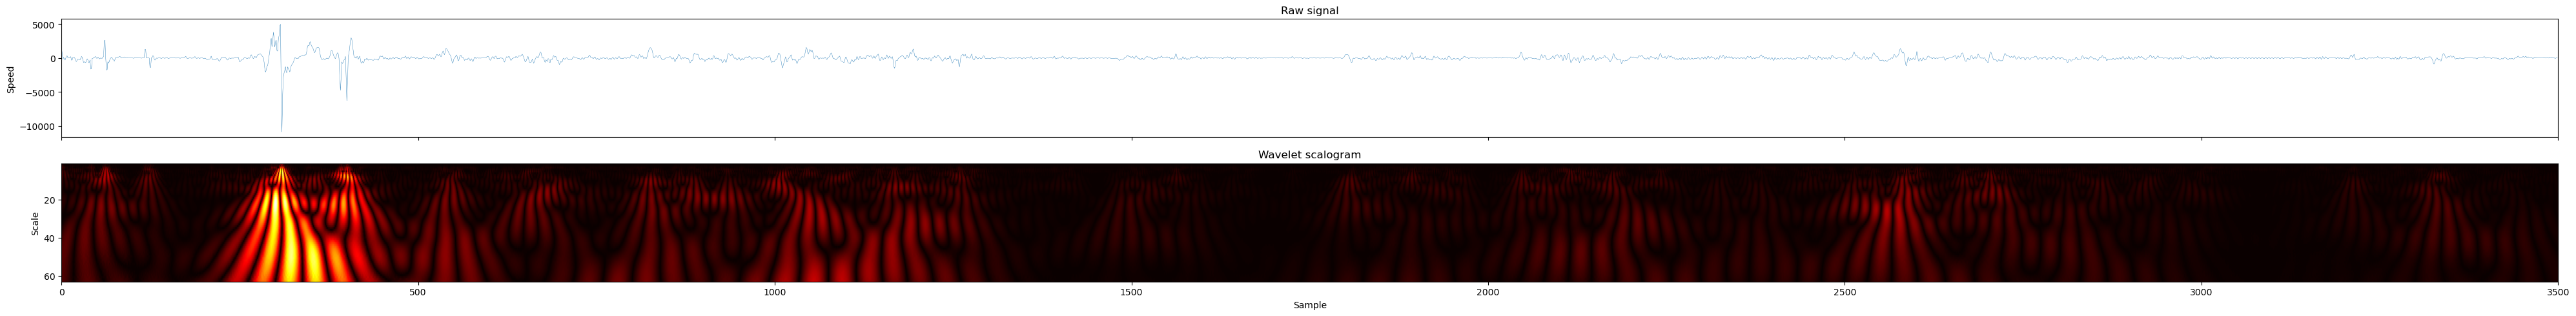

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(40, 5), sharex=True)

axes[0].plot(signal_clean, linewidth=0.3)
axes[0].set_ylabel("Speed")
axes[0].set_title("Raw signal")

axes[1].imshow(
    np.abs(coeffs), aspect='auto', cmap='hot',
    extent=[0, len(signal_clean), widths[-1], widths[0]]
)
axes[1].set_ylabel("Scale")
axes[1].set_xlabel("Sample")
axes[1].set_title("Wavelet scalogram")

plt.tight_layout()
plt.show()

In [30]:
voc.examples.show()

VocalPy example data
name: bells.wav
description:
Zebra finch song from Sound Analysis Pro website:  
http://soundanalysispro.com/

name: flashcam.wav
description:
Zebra finch song from Sound Analysis Pro website:  
http://soundanalysispro.com/

name: samba.wav
description:
Zebra finch song from Sound Analysis Pro website:  
http://soundanalysispro.com/

name: simple.wav
description:
Zebra finch song from Sound Analysis Pro website:  
http://soundanalysispro.com/

name: BM003.wav
description:
Mouse ultrasonic vocalization from:
Goffinet, J., Brudner, S., Mooney, R., & Pearson, J. (2021).
Data from: Low-dimensional learned feature spaces quantify individual and group differences
in vocal repertoires. Duke Research Data Repository. https://doi.org/10.7924/r4gq6zn8w.
Adapted under Creative Commons License 1.0: https://creativecommons.org/publicdomain/zero/1.0/.
File name in dataset: BM003_day9_air_20s_sparse_chunk007_0297.wav

name: bl26lb16.wav
description:
Bengalese finch song from:
Ben

In [39]:
jourjineetal2023paths

WindowsPath('c:/Users/aksel/anaconda3/envs/ethograph/Lib/site-packages/vocalpy/examples/bells.wav')

In [50]:
sound[0, :]

vocalpy.Sound(data=array([[0.001...(1, 10240000)), samplerate=24414)

In [47]:
wav_path = r"C:\Users\aksel\Documents\Code\EthoGraph\data\copExpBP08\audio.wav"
import vocalpy as voc
sound = voc.Sound.read(wav_path)
segments = voc.segment.ava(sound[0, :])
segments

UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('O') to dtype('float32') with casting rule 'same_kind'

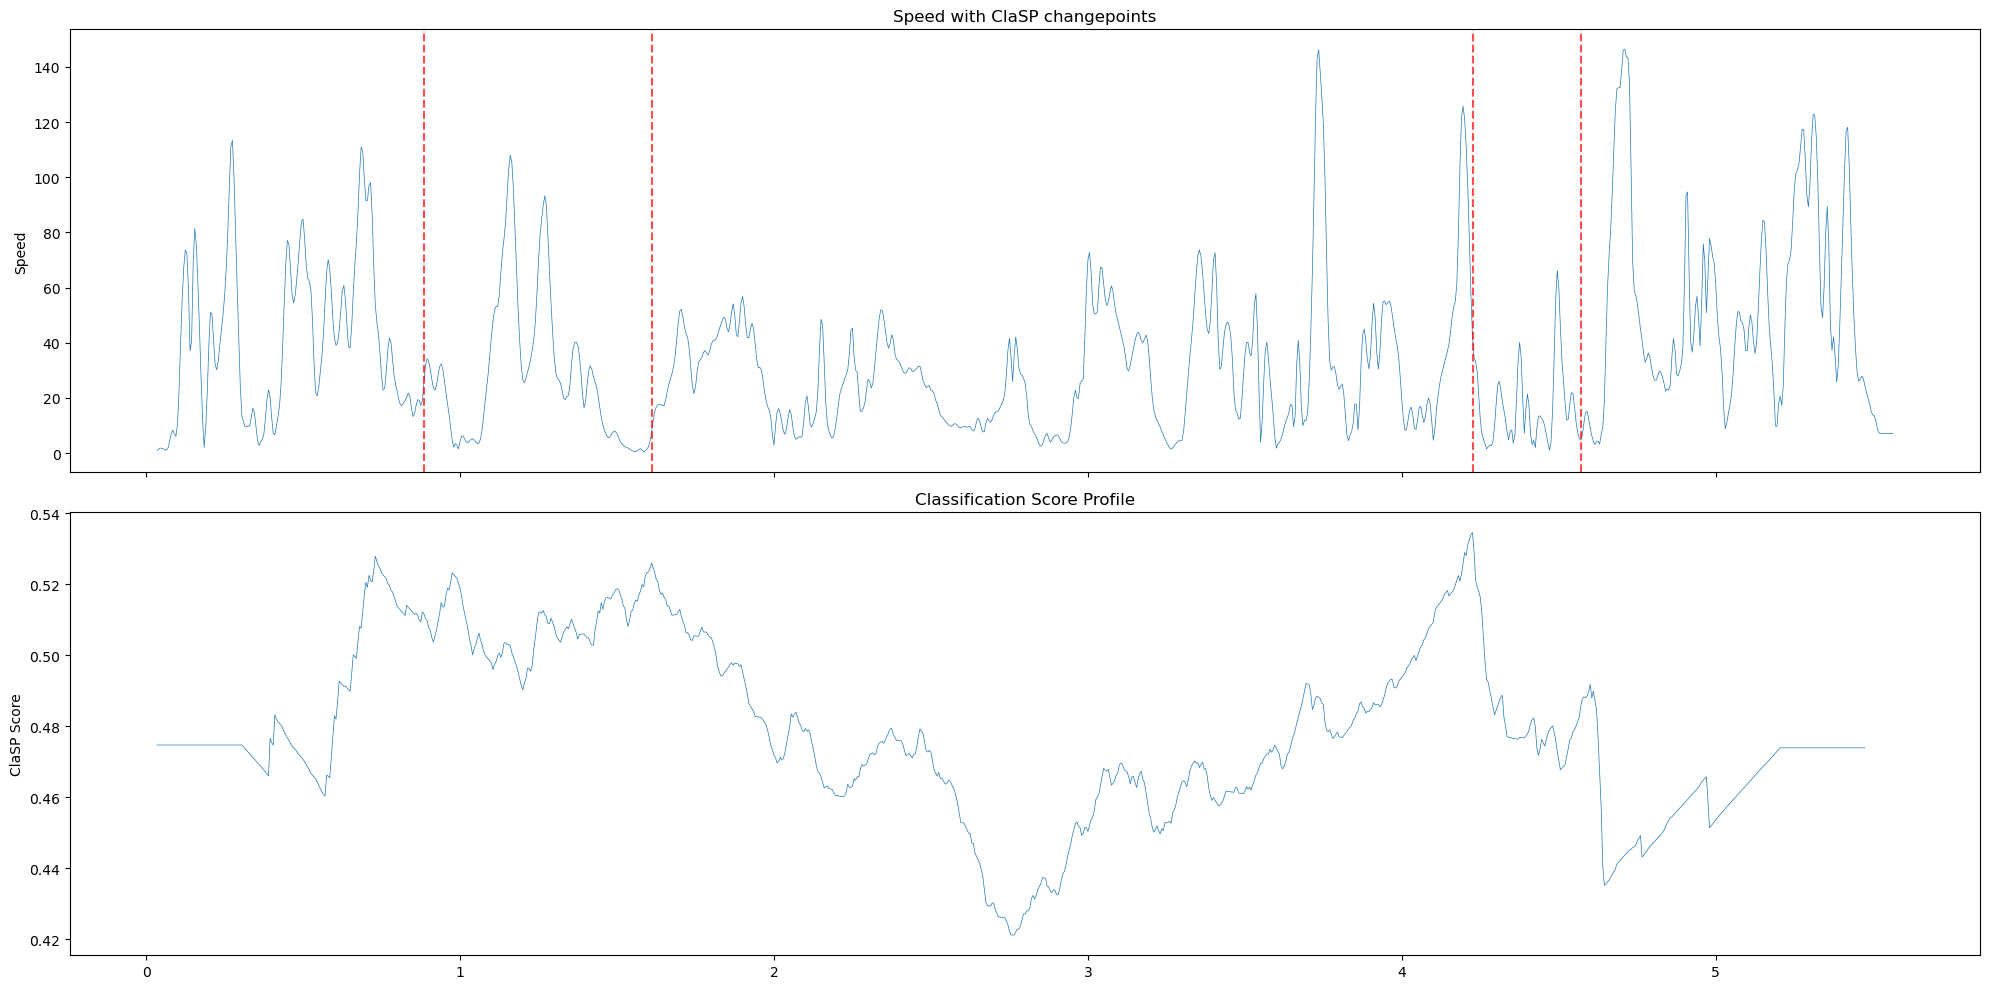

In [37]:
from sktime.detection.clasp import ClaSPSegmentation, find_dominant_window_sizes
import matplotlib.pyplot as plt
import numpy as np

ds_kwargs = {"keypoints": "beakTip"}
trial = dt.itrial(1)

speed = trial["speed"].sel(**ds_kwargs).squeeze().values
time = trial["time"].values

mask = ~np.isnan(speed)
speed_clean = speed[mask]
time_clean = time[mask]

dominant_period = find_dominant_window_sizes(speed_clean)
clasp = ClaSPSegmentation(period_length=dominant_period, n_cps=30)
changepoints = clasp.fit_predict(speed_clean).values.astype(int)

fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

axes[0].plot(time_clean, speed_clean, linewidth=0.5)
for cp in changepoints:
    axes[0].axvline(x=time_clean[cp], color='red', linestyle='--', alpha=0.7)
axes[0].set_ylabel("Speed")
axes[0].set_title("Speed with ClaSP changepoints")

profiles = clasp.profiles
if len(profiles) > 0:
    profile = profiles[0]
    axes[1].plot(time_clean[:len(profile)], profile, linewidth=0.5)
    axes[1].set_ylabel("ClaSP Score")
    axes[1].set_title("Classification Score Profile")

plt.tight_layout()
plt.show()

c:\Users\aksel\anaconda3\envs\ethograph\Lib\site-packages\sktime\transformations\series\_clasp_numba.py:52: RuntimeWarning: invalid value encountered in sqrt
  movstd = np.sqrt(segSumSq / m - (segSum / m) ** 2)


ClaSP changepoints: [4616 4262 3807 3089 2605]
PELT changepoints:  [   1    2    3 ... 5076 5083 5084]
MovingWindow CPs:   [  30  162  207  356  419  515  560  656  913 1022 1042 1071 1113 1353
 1651 2545 2931 3190 3654 4314 4335 4464 4540 4572 4592 4919 5007]


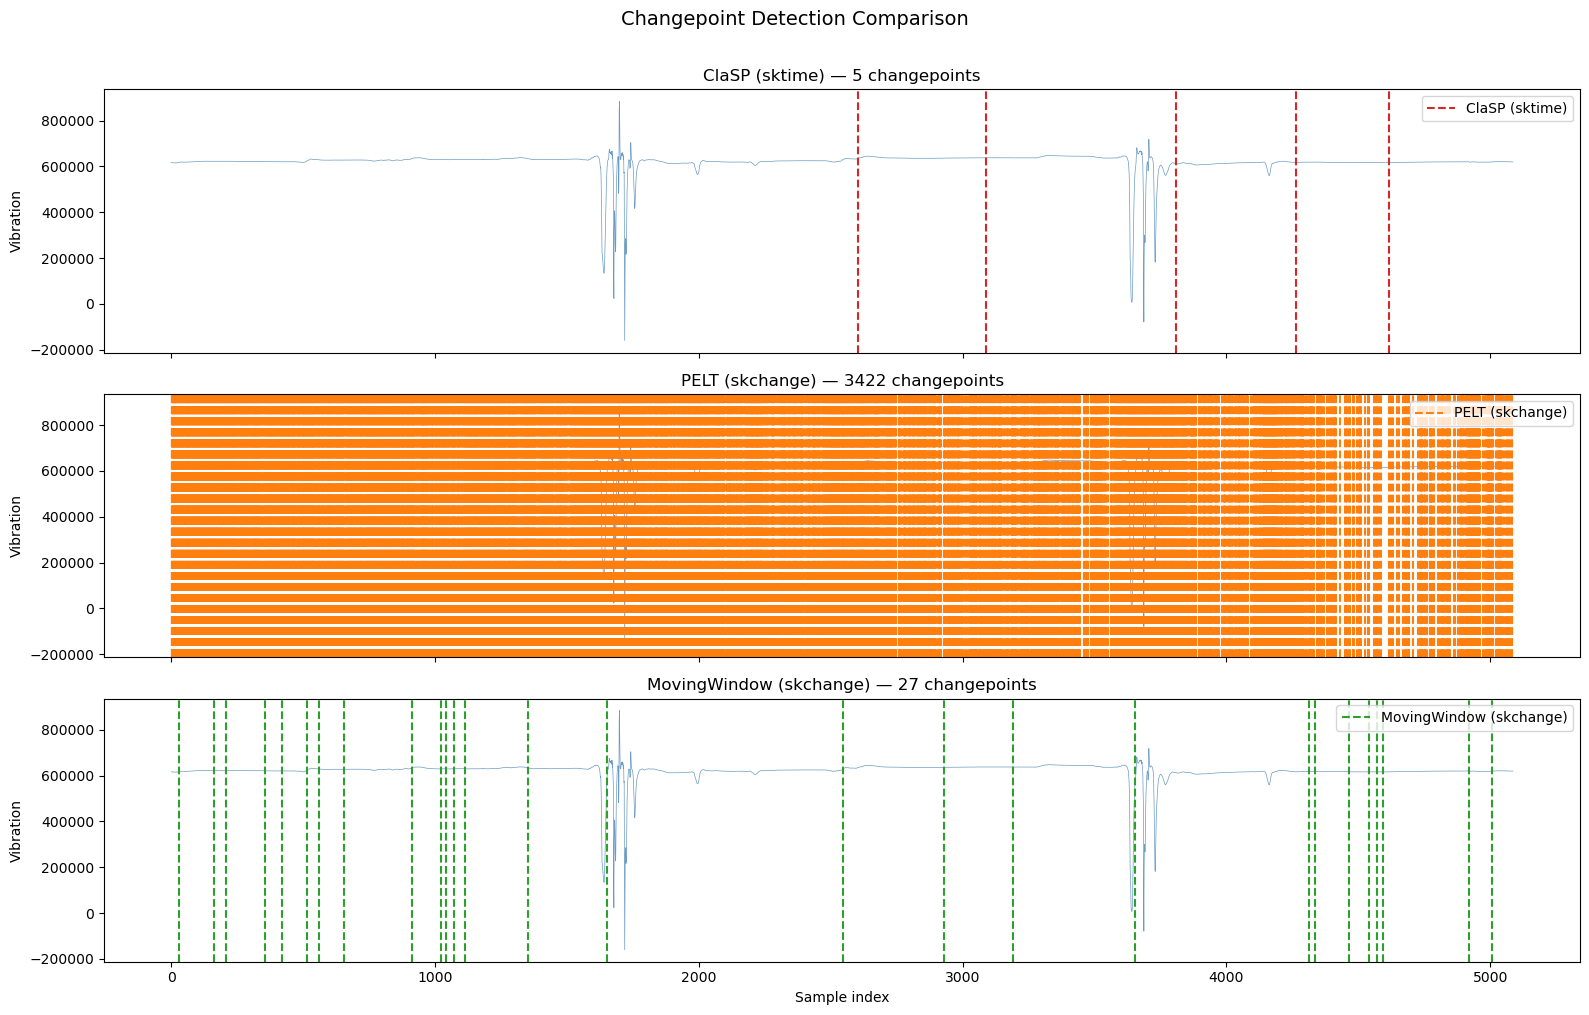

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


# --- Load signal ---
path = Path(r"C:\Users\aksel\Documents\Code\EthoGraph\tests\test_data\copExpBP08_trim.nc")

# Since we can't run ethograph here, we'll structure the script
# for you to run locally. But let's first inspect what we're working with.

# Uncomment for local use:
from ethograph import TrialTree
dt = TrialTree.open(path)
signal = dt.itrial(0)["vibration (accelerometer)"].isel(individuals=0).values

from scipy.signal import decimate

signal = decimate(signal, q=24) 

series = pd.Series(signal, name="vibration")

# ============================================================
# Method 1: ClaSP (sktime)
# ============================================================
from sktime.detection.clasp import ClaSPSegmentation

# period_length: expected minimum segment length
# n_cps: number of changepoints to find
# Tip: start with n_cps higher than expected, inspect results
clasp = ClaSPSegmentation(n_cps=5)
clasp.fit(series)
clasp_cps = clasp.predict(series)
clasp_cp_values = clasp_cps.values.flatten()
print(f"ClaSP changepoints: {clasp_cp_values}")

# ============================================================
# Method 2: skchange Pelt (automatic number of changepoints)
# ============================================================
from skchange.change_detectors import PELT

df = pd.DataFrame({"vibration": signal})
pelt = PELT()
pelt_result = pelt.fit_predict(df)
pelt_cp_values = pelt_result.values.flatten()
print(f"PELT changepoints:  {pelt_cp_values}")

# ============================================================
# Method 3: skchange MovingWindow
# ============================================================
from skchange.change_detectors import MovingWindow

mw = MovingWindow()
mw_result = mw.fit_predict(df)
mw_cp_values = mw_result.values.flatten()
print(f"MovingWindow CPs:   {mw_cp_values}")

# ============================================================
# Plot comparison
# ============================================================
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)
methods = [
    ("ClaSP (sktime)", clasp_cp_values, "tab:red"),
    ("PELT (skchange)", pelt_cp_values, "tab:orange"),
    ("MovingWindow (skchange)", mw_cp_values, "tab:green"),
]

for ax, (name, cps, color) in zip(axes, methods):
    ax.plot(signal, color="steelblue", lw=0.5, alpha=0.8)
    for i, cp in enumerate(cps):
        ax.axvline(cp, color=color, ls="--", lw=1.5, label=name if i == 0 else None)
    ax.set_ylabel("Vibration")
    ax.set_title(f"{name} — {len(cps)} changepoints")
    ax.legend(loc="upper right")

axes[-1].set_xlabel("Sample index")
plt.suptitle("Changepoint Detection Comparison", fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig("changepoint_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

In [5]:
from skchange import change_detectors
print(dir(change_detectors))

['BASE_CHANGE_DETECTORS', 'BaseChangeDetector', 'CHANGE_DETECTORS', 'CROPS', 'MovingWindow', 'PELT', 'SeededBinarySegmentation', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_crops', '_moving_window', '_pelt', '_seeded_binseg', 'base']


In [ ]:
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt



# --- Changepoint detection on multivariate signal ---
# Input shape: (n_samples, n_dims) — ruptures handles this natively
algo = rpt.Pelt(model="rbf").fit(signal)
predicted_cps = algo.predict(pen=3.0)
# Last element is always n_samples, drop it for plotting
predicted_cps = predicted_cps[:-1]


print(f"Predicted: {predicted_cps}")

# --- Plot ---
dim_labels = ["x", "y", "z"]
fig, axes = plt.subplots(1, 1, figsize=(14, 8), sharex=True)

for d, ax in enumerate(axes):
    ax.plot(signal[:, d], color="steelblue", lw=0.8)
    ax.set_ylabel(dim_labels[d])


axes[0].set_title("Multivariate Changepoint Detection (ruptures Pelt)")

# Manual legend
from matplotlib.lines import Line2D
axes[0].legend(
    [Line2D([0], [0], color="green", ls="--"), Line2D([0], [0], color="red", ls=":")],
    ["True CP", "Predicted CP"],
)

axes[-1].set_xlabel("Time index")
plt.tight_layout()
plt.savefig("multivariate_changepoints.png", dpi=150)
plt.show()

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skchange.change_detectors.pelt import Pelt

# --- Synthetic signal with unknown number of regime changes ---
rng = np.random.default_rng(42)
segments = [
    np.sin(np.linspace(0, 4 * np.pi, 200)) + 0.1 * rng.standard_normal(200),
    0.5 * np.ones(100) + 0.1 * rng.standard_normal(100),
    2 * np.sin(np.linspace(0, 8 * np.pi, 150)) + 0.2 * rng.standard_normal(150),
    -1 * np.ones(100) + 0.15 * rng.standard_normal(100),
]
true_cps = [200, 300, 450]
signal = np.concatenate(segments)
df = pd.DataFrame({"value": signal})

# --- PELT: automatic number of changepoints via penalized likelihood ---
detector = Pelt()
changepoints = detector.fit_predict(df)

print(f"True:      {true_cps}")
print(f"Predicted: {list(changepoints.values.flatten())}")

ModuleNotFoundError: No module named 'skchange.change_detectors.pelt'